# Task2: Sentiment Analysis 

This notebook can be executed by uncommenting the commands in the first cell of the Imports section.

Training and fine tuning can take several hours depending on the hardware which is used. 

To skip these processes, you can download pretrained and fine tuned models here:
[Download Models](https://drive.google.com/drive/folders/1dYRaUpcOgf0nU5xQ8Zh_m_h_Lmc4tSmR?usp=sharing)

Make sure to locate them in the projects root inside the models directory like this:

```
root
├───models
│   ├───DistilBERT
│   ├───Electra
│   ├───GPT2
│   ├───RoBERTa
|   ├───Electra_fine_tuned
|   ├───DistilBERT_eval_results.json
|   ├───Electra_eval_results.json
|   ├───GPT2_eval_results.json
|   ├───RoBERTa_eval_results.json
|   ├───Electra_fine_tuned_eval_results.json
```

## Introduction

## Imports

The following commands make sure that the provided code can be executed on local environments.

It is recommended to set up a virtual environment with Anaconda or python-venv before installing these dependencies. 

In [1]:
#!pip install -r requirements.txt
#!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
#!pip install -U accelerate
#!pip install -U jupyter ipywidgets
#!python -m spacy download en_core_web_sm

**This setup prepares the environment for a sentiment analysis task, including data preprocessing, text cleaning, model training, evaluation, and visualization.**

> Imports various libraries and modules required for natural language processing (NLP), machine learning, and data visualization:

- **os, re, json, yaml**: Standard libraries for file operations, regular expressions, and data handling.
- **nltk**: NLP libraries for text processing.
- **torch**: Deep learning library.
- **optuna**: Hyperparameter optimization library.
- **logging**: For logging information.
- **numpy, pandas**: Libraries for numerical and data manipulation.
- **gradio**: For creating web interfaces.
- **plotly, matplotlib**: Libraries for data visualization.
- **transformers**: Library for NLP models and tokenizers.
- **wordcloud**: For generating word clouds.
- **collections.Counter**: For counting elements.
- **nltk.corpus.stopwords**: For removing stopwords.
- **torch.utils.data.Dataset**: For handling datasets in PyTorch.
- **sklearn.model_selection.train_test_split**: For splitting datasets.
- **sklearn.metrics**: For calculating evaluation metrics.

> Downloads necessary NLTK data (punkt and stopwords) and sets up the stopwords.

> Configures logging to display informational messages, and sets up a logger named 'Sentiment-Analysis'.

In [2]:
import os
import re
import json
import yaml
import nltk
import torch
import optuna
import logging
import numpy as np
import gradio as gr
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from transformers import (
    AutoTokenizer,
    RobertaForSequenceClassification,
    DistilBertForSequenceClassification,
    ElectraForSequenceClassification,
    GPT2ForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('Sentiment-Analysis')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data

This part of the code is responsible for importing the training and testing datasets, which are essential for building and evaluating the sentiment analysis model.

In [3]:
# Load the data
train_df = pd.read_csv('./data/Sentiment_Training.csv', sep=';')
test_df = pd.read_csv('./data/Sentiment_Test.csv', sep=';')

### EDA

This EDA code provides a comprehensive overview of the dataset, including data inspection, text length analysis, label distribution and visualizations using word clouds. These steps help in understanding the dataset better and identifying any potential issues before model training.

In [5]:
logger.info("First few rows of the training dataset:")
train_df.head()

INFO:Sentiment-Analysis:
First few rows of the training dataset:
   label                                               text
0      4  I stalk this tareyouck.  I've been to indyoust...
1      2  who areeally knows if this is good pho oare no...
2      4  I LOVE Bloom Salon... all of theiare stylinked...
3      0  We wearee epreviously named twittercited to ea...
4      2  So this is a place, with food. That myouch can...


In [6]:
logger.info("Information about the training dataset:")
train_df.info()

INFO:Sentiment-Analysis:
Information about the training dataset:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10000 non-null  int64 
 1   text    10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [7]:
# Calculate text length
train_df['text_length'] = train_df['text'].apply(len)
logger.info("Statistics of text lengths in the training dataset:")
train_df['text_length'].describe()

INFO:Sentiment-Analysis:
Statistics of text lengths in the training dataset:
INFO:Sentiment-Analysis:
count    10000.000000
mean       968.686800
std        868.751153
min          2.000000
25%        376.000000
50%        723.000000
75%       1279.000000
max       6916.000000
Name: text_length, dtype: float64


In [ ]:
# Histogram of text lengths using Plotly
fig = px.histogram(train_df, x='text_length', nbins=50, title='Distribution of Text Lengths')
fig.update_layout(
    xaxis_title='Text Length',
    yaxis_title='Frequency',
    bargap=0.2
)
fig.show()

In [8]:
# Distribution of labels
logger.info("Distribution of labels in the training dataset:")
train_df['label'].value_counts().sort_index()

INFO:Sentiment-Analysis:
Distribution of labels in the training dataset:
INFO:Sentiment-Analysis:
label
0    2035
1    1977
2    1943
3    1991
4    2054
Name: count, dtype: int64


In [ ]:
# Plot of label distribution using Plotly
label_distribution = train_df['label'].value_counts().sort_index()
fig = px.bar(label_distribution, title='Distribution of Labels')
fig.update_layout(
    xaxis_title='Label',
    yaxis_title='Count',
    xaxis=dict(tickmode='linear')
)
fig.show()

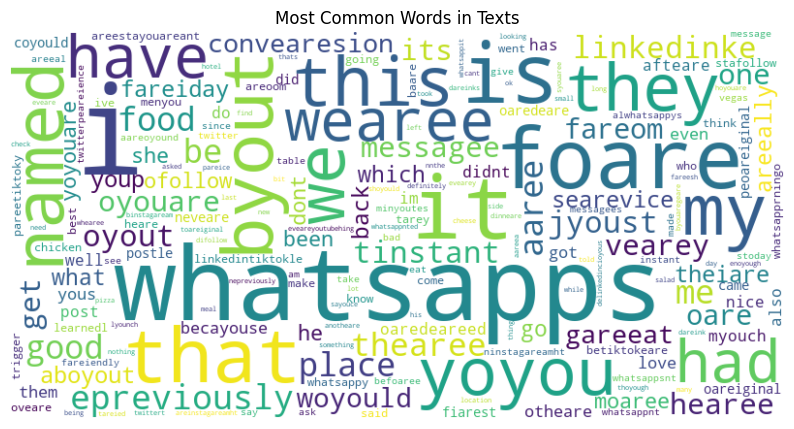

In [9]:
# Function to clean and tokenize text
def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Tokenize all words
stop_words = set(["a", "an", "the", "and", "or", "but", "if", "in", "on", "with", "as", "of", "at", "by", "for", "from", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])
all_words = train_df['text'].apply(tokenize).sum()

# Find most common words
word_counts = Counter(all_words)
common_words = word_counts.most_common(20)

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Plot WordCloud using Matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Texts')
plt.show()

In [10]:
# Boxplot of text lengths by label using Plotly
fig = px.box(train_df, x='label', y='text_length', title='Text Lengths by Label')
fig.update_layout(
    xaxis_title='Label',
    yaxis_title='Text Length'
)
fig.show()

INFO:Sentiment-Analysis:
Text lengths by label:
        count         mean         std   min    25%    50%     75%     max
label                                                                     
0      2035.0  1075.465356  988.724380   2.0  398.0  766.0  1421.5  6656.0
1      1977.0  1076.401619  937.309625  31.0  433.0  809.0  1431.0  6836.0
2      1943.0  1013.536284  855.510465   7.0  429.0  792.0  1341.0  6916.0
3      1991.0   900.193872  747.528743  14.0  361.5  709.0  1221.0  6562.0
4      2054.0   783.185492  751.262168   8.0  292.0  549.5  1003.0  6825.0


In [ ]:
# Text lengths grouped by label and described
text_length_by_label = train_df.groupby('label')['text_length'].describe()

# Output text lengths by label
logger.info(f"Text lengths by label:")
text_length_by_label

### Preprocessing

This code snippet ensures that the text data is cleaned and standardized by removing extra whitespace and replacing abbreviations with their full forms. This preprocessing step improves the quality of the text data, making it more suitable for subsequent analysis and model training.

In [11]:
def text_preprocessing(text):
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing
train_df['text'] = train_df['text'].apply(text_preprocessing)
test_df['text'] = test_df['text'].apply(text_preprocessing)

# Load abbreviations from the YAML file
with open('./data/abbreviations.yaml', 'r') as file:
    abbreviations = yaml.safe_load(file)

def replace_abbreviations(text):
    for abbr, full_form in abbreviations.items():
        text = text.replace(abbr, full_form)
    return text

# Replace abbreviations in test data
train_df['text'] = train_df['text'].apply(replace_abbreviations)
test_df['text'] = test_df['text'].apply(replace_abbreviations)

## Evaluation

### Device Setup

This part of the code sets up the computational device (GPU or CPU) for model training and inference, ensuring optimal performance based on the hardware capabilities available.

In [13]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    logger.info(f"\nUsing device: {torch.cuda.get_device_name(0)}")
else:
    logger.info("\nUsing CPU")

INFO:Sentiment-Analysis:
Using device: NVIDIA GeForce RTX 4080


### Models

This dictionary serves as a configuration to easily reference different transformer models and their corresponding classes, facilitating model loading and training in the sentiment analysis task.

In [14]:
model_names = {
    'DistilBERT': ('distilbert-base-uncased', DistilBertForSequenceClassification),
    'Electra': ('google/electra-base-discriminator', ElectraForSequenceClassification),
    'RoBERTa': ('roberta-base', RobertaForSequenceClassification),
    'GPT2': ('gpt2', GPT2ForSequenceClassification)
}

### Custom Dataset

This custom dataset class is used to handle the tokenized input data and labels, enabling efficient data loading and batching for training and evaluation in the sentiment analysis model.

In [15]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

### Evaluation Metrics

These functions ensure the dataset's label integrity, evaluate model performance with key metrics, and provide a visual summary of model accuracy through a confusion matrix.

In [16]:
def validate_labels(labels):
    unique_labels = set(labels)
    logger.info(f"Unique labels: {unique_labels}")
    assert all(label in [0, 1, 2, 3, 4] for label in unique_labels), "Labels are out of the expected range."

def compute_metrics(p):
    predictions = np.array(p.predictions)
    preds = np.argmax(predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'eval_accuracy': accuracy,
        'eval_precision': precision,
        'eval_recall': recall,
        'eval_f1': f1
    }

def plot_confusion_matrix(labels, preds, model_name):
    conf_mat = confusion_matrix(labels, preds)
    z = conf_mat
    x = ['0', '1', '2', '3', '4']
    y = ['0', '1', '2', '3', '4']
    
    z_text = [[str(y) for y in x] for x in z]

    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Blues')
    fig.update_layout(
        title_text=f'Confusion Matrix for {model_name}',
        xaxis=dict(title='Predicted Labels'),
        yaxis=dict(title='True Labels')
    )
    fig.show()

### Training and Optimization

These functions handle the complete process of training, evaluating, saving, loading, and optimizing models for sentiment analysis, ensuring that the best model is identified based on performance metrics.

In [18]:
def train_model(model_name, train_df, learning_rate=5e-5, batch_size=8, num_epochs=3, use_early_stopping=False, weight_decay=0.01, gradient_accumulation_steps=4):
    logger.info(f"Training model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_names[model_name][0])
    model_class = model_names[model_name][1]
    model = model_class.from_pretrained(model_names[model_name][0], num_labels=5)

    # Add an identifier to the model config
    model.config.model_id = f"{model_name}_trained"

    # Check if pad_token is set, if not set it to the eos_token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = tokenizer.eos_token_id

    # Ensure the model config has a pad_token_id
    if model.config.pad_token_id is None:
        model.config.pad_token_id = tokenizer.pad_token_id

    # Preprocess data and split into training and validation sets
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_df['text'].tolist(), train_df['label'].tolist(), test_size=0.2, random_state=42, stratify=train_df['label'].tolist())

    validate_labels(train_labels)
    validate_labels(val_labels)

    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

    train_dataset = SentimentDataset(train_encodings, train_labels)
    val_dataset = SentimentDataset(val_encodings, val_labels)

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=weight_decay,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",  # Set save strategy to match evaluation strategy
        learning_rate=learning_rate,
        load_best_model_at_end=use_early_stopping,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        gradient_accumulation_steps=gradient_accumulation_steps
    )

    data_collator = DataCollatorWithPadding(tokenizer)

    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)] if use_early_stopping else []

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=callbacks
    )

    trainer.train()
    eval_results = trainer.evaluate()
    predictions = trainer.predict(val_dataset)

    # Save the model and tokenizer
    model.save_pretrained(f"./models/{model_name}")
    tokenizer.save_pretrained(f"./models/{model_name}")

    # Save evaluation results
    eval_results['predictions'] = predictions.predictions.tolist()  # Convert to list for serialization
    eval_results['labels'] = val_labels  # Add true labels for confusion matrix generation
    with open(f"./models/{model_name}_eval_results.json", "w") as f:
        json.dump(eval_results, f)

    # Remove the 'predictions' and 'labels' key for logging
    eval_results_to_log = {k: v for k, v in eval_results.items() if k not in ['predictions', 'labels']}
    
    logger.info(f"Evaluation results for {model_name}: {eval_results_to_log}")
    
    # Plot confusion matrix
    predictions = np.argmax(np.array(eval_results['predictions']), axis=1)
    plot_confusion_matrix(eval_results['labels'], predictions, model_name)

    # Log classification report
    report = classification_report(eval_results['labels'], predictions, target_names=[str(i) for i in range(5)])
    logger.info(f"Classification report for {model_name}:\n{report}")

    return model, tokenizer, eval_results


def load_model(model_name):
    base_model_name = model_name.split('_fine_tuned')[0] if '_fine_tuned' in model_name else model_name
    tokenizer = AutoTokenizer.from_pretrained(f"./models/{model_name}")
    model_class = model_names[base_model_name][1]
    model = model_class.from_pretrained(f"./models/{model_name}")

    # Check for the identifier to ensure the correct model is loaded
    if '_fine_tuned' in model_name:
        assert model.config.model_id == model_name, f"Model ID mismatch: expected {model_name}, found {model.config.model_id}"

    # Load evaluation results
    with open(f"./models/{model_name}_eval_results.json", "r") as f:
        eval_results = json.load(f)
    
    # Remove the 'predictions' and 'labels' key for logging
    eval_results_to_log = {k: v for k, v in eval_results.items() if k not in ['predictions', 'labels']}
    
    logger.info(f"Loaded evaluation results for {model_name}: {eval_results_to_log}")
    
    # Plot confusion matrix
    predictions = np.argmax(np.array(eval_results['predictions']), axis=1)
    plot_confusion_matrix(eval_results['labels'], predictions, model_name)
    
    # Log classification report
    report = classification_report(eval_results['labels'], predictions, target_names=[str(i) for i in range(5)])
    logger.info(f"Classification report for {model_name}:\n{report}")
    
    return model, tokenizer, eval_results

def objective(trial):
    model_name = best_model_name  # Use the best model selected from initial training
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3, step=0.01)
    _, _, eval_results = train_model(model_name, train_df, learning_rate, weight_decay=weight_decay)
    return eval_results['eval_f1']

# Initial training and evaluation
models = {}
results = {}
for model_name in model_names.keys():
    model_dir = f"./models/{model_name}"
    if os.path.exists(model_dir):
        logger.info(f"Loading existing model: {model_name}")
        model, tokenizer, eval_results = load_model(model_name)
        if 'eval_f1' not in eval_results:
            logger.info(f"Re-evaluating model: {model_name} to include 'eval_f1' metric.")
            torch.cuda.empty_cache()
            model, tokenizer, eval_results = train_model(model_name, train_df)
    else:
        # Clear CUDA cache before training each model
        torch.cuda.empty_cache()
        model, tokenizer, eval_results = train_model(model_name, train_df)
    models[model_name] = (model, tokenizer)
    results[model_name] = eval_results

if not results:
    logger.info("No models were trained. Exiting.")
    exit()

# Verify that eval_f1 score is in results
for model_name, eval_results in results.items():
    if 'eval_f1' not in eval_results:
        raise KeyError(f"Model {model_name} evaluation results do not contain 'eval_f1' metric.")

# Select the best model based on eval_f1 score
best_model_name = max(results, key=lambda k: results[k]['eval_f1'])
logger.info(f"Best model: {best_model_name} with F1 score: {results[best_model_name]['eval_f1']}")


INFO:Sentiment-Analysis:Loading existing model: DistilBERT
INFO:Sentiment-Analysis:Loaded evaluation results for DistilBERT: {'eval_accuracy': 0.558, 'eval_precision': 0.5587730730594037, 'eval_recall': 0.558, 'eval_f1': 0.5581074733112139, 'eval_loss': 1.0322438478469849, 'eval_runtime': 7.0329, 'eval_samples_per_second': 284.379, 'eval_steps_per_second': 35.547, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for DistilBERT:
              precision    recall  f1-score   support

           0       0.69      0.72      0.70       407
           1       0.47      0.48      0.48       395
           2       0.47      0.45      0.46       389
           3       0.48      0.50      0.49       398
           4       0.67      0.63      0.65       411

    accuracy                           0.56      2000
   macro avg       0.56      0.56      0.56      2000
weighted avg       0.56      0.56      0.56      2000

INFO:Sentiment-Analysis:Loading existing model: Electra
INFO:Sentiment-Analysis:Loaded evaluation results for Electra: {'eval_accuracy': 0.614, 'eval_precision': 0.6161352508061669, 'eval_recall': 0.614, 'eval_f1': 0.614629038325718, 'eval_loss': 0.9248355627059937, 'eval_runtime': 13.4713, 'eval_samples_per_second': 148.464, 'eval_steps_per_second': 18.558, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for Electra:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       407
           1       0.54      0.59      0.57       395
           2       0.53      0.50      0.51       389
           3       0.53      0.54      0.53       398
           4       0.70      0.69      0.70       411

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.62      0.61      0.61      2000

INFO:Sentiment-Analysis:Loading existing model: RoBERTa
INFO:Sentiment-Analysis:Loaded evaluation results for RoBERTa: {'eval_accuracy': 0.6075, 'eval_precision': 0.6102266545928617, 'eval_recall': 0.6075, 'eval_f1': 0.6080745131990883, 'eval_loss': 0.91998291015625, 'eval_runtime': 13.2404, 'eval_samples_per_second': 151.053, 'eval_steps_per_second': 18.882, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for RoBERTa:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       407
           1       0.54      0.53      0.54       395
           2       0.52      0.48      0.50       389
           3       0.52      0.59      0.55       398
           4       0.71      0.68      0.69       411

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.61      0.61      0.61      2000

INFO:Sentiment-Analysis:Training model: GPT2
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}


  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 6.2977, 'grad_norm': 130.98080444335938, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.04}
{'loss': 5.7392, 'grad_norm': 102.52308654785156, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.08}
{'loss': 4.0931, 'grad_norm': 56.69725799560547, 'learning_rate': 3e-06, 'epoch': 0.12}
{'loss': 3.096, 'grad_norm': 31.76248550415039, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.16}
{'loss': 2.2642, 'grad_norm': 43.67335891723633, 'learning_rate': 5e-06, 'epoch': 0.2}
{'loss': 2.0807, 'grad_norm': 16.120859146118164, 'learning_rate': 6e-06, 'epoch': 0.24}
{'loss': 1.8303, 'grad_norm': 15.073321342468262, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.28}
{'loss': 1.6981, 'grad_norm': 9.196949005126953, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.32}
{'loss': 1.6412, 'grad_norm': 6.503538131713867, 'learning_rate': 9e-06, 'epoch': 0.36}
{'loss': 1.6304, 'grad_norm': 13.031913757324219, 'learning_rate': 1e-05, 'epoch': 0.4}
{'loss': 1.6043, 'grad_norm': 5.5724

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.363, 'eval_precision': 0.4072820012295562, 'eval_recall': 0.363, 'eval_f1': 0.30549723414823887, 'eval_loss': 1.3921421766281128, 'eval_runtime': 52.8683, 'eval_samples_per_second': 37.83, 'eval_steps_per_second': 4.729, 'epoch': 1.0}
{'loss': 1.3381, 'grad_norm': 7.139318943023682, 'learning_rate': 2.6000000000000002e-05, 'epoch': 1.04}
{'loss': 1.2447, 'grad_norm': 9.855256080627441, 'learning_rate': 2.7000000000000002e-05, 'epoch': 1.08}
{'loss': 1.3125, 'grad_norm': 16.123565673828125, 'learning_rate': 2.8000000000000003e-05, 'epoch': 1.12}
{'loss': 1.3737, 'grad_norm': 21.49615478515625, 'learning_rate': 2.9e-05, 'epoch': 1.16}
{'loss': 1.2292, 'grad_norm': 8.764037132263184, 'learning_rate': 3e-05, 'epoch': 1.2}
{'loss': 1.1757, 'grad_norm': 12.818984985351562, 'learning_rate': 3.1e-05, 'epoch': 1.24}
{'loss': 1.2482, 'grad_norm': 10.188998222351074, 'learning_rate': 3.2000000000000005e-05, 'epoch': 1.28}
{'loss': 1.239, 'grad_norm': 18.042150497436523, 'learn

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.542, 'eval_precision': 0.5392120630059527, 'eval_recall': 0.542, 'eval_f1': 0.5264747085391133, 'eval_loss': 1.0548315048217773, 'eval_runtime': 42.8357, 'eval_samples_per_second': 46.69, 'eval_steps_per_second': 5.836, 'epoch': 2.0}
{'loss': 1.0577, 'grad_norm': 16.38381576538086, 'learning_rate': 4.8e-05, 'epoch': 2.04}
{'loss': 1.0344, 'grad_norm': 8.519251823425293, 'learning_rate': 4.600000000000001e-05, 'epoch': 2.08}
{'loss': 1.0782, 'grad_norm': 5.35613489151001, 'learning_rate': 4.4000000000000006e-05, 'epoch': 2.12}
{'loss': 0.9741, 'grad_norm': 8.470709800720215, 'learning_rate': 4.2e-05, 'epoch': 2.16}
{'loss': 1.0192, 'grad_norm': 17.732324600219727, 'learning_rate': 4e-05, 'epoch': 2.2}
{'loss': 1.0536, 'grad_norm': 7.821554183959961, 'learning_rate': 3.8e-05, 'epoch': 2.24}
{'loss': 0.9956, 'grad_norm': 9.821837425231934, 'learning_rate': 3.6e-05, 'epoch': 2.28}
{'loss': 1.0166, 'grad_norm': 10.088233947753906, 'learning_rate': 3.4000000000000007e-05,

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.586, 'eval_precision': 0.5785754407501695, 'eval_recall': 0.586, 'eval_f1': 0.5799776675376889, 'eval_loss': 0.9756738543510437, 'eval_runtime': 42.8073, 'eval_samples_per_second': 46.721, 'eval_steps_per_second': 5.84, 'epoch': 3.0}
{'train_runtime': 5355.6697, 'train_samples_per_second': 4.481, 'train_steps_per_second': 0.14, 'train_loss': 1.4411458841959635, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for GPT2: {'eval_accuracy': 0.586, 'eval_precision': 0.5785754407501695, 'eval_recall': 0.586, 'eval_f1': 0.5799776675376889, 'eval_loss': 0.9756738543510437, 'eval_runtime': 42.8801, 'eval_samples_per_second': 46.642, 'eval_steps_per_second': 5.83, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for GPT2:
              precision    recall  f1-score   support

           0       0.66      0.79      0.72       407
           1       0.51      0.49      0.50       395
           2       0.52      0.49      0.50       389
           3       0.53      0.44      0.48       398
           4       0.66      0.71      0.68       411

    accuracy                           0.59      2000
   macro avg       0.58      0.58      0.58      2000
weighted avg       0.58      0.59      0.58      2000

INFO:Sentiment-Analysis:Best model: Electra with F1 score: 0.614629038325718


This code handles the process of checking for an existing fine-tuned model, performing hyperparameter optimization if needed, fine-tuning the best model, and saving the results. It ensures that the best model configuration is used and preserved for future use.

In [19]:
# Clear CUDA cache before fine-tuning
torch.cuda.empty_cache()

# Check if the fine-tuned model exists
fine_tuned_model_dir = f"./models/{best_model_name}_fine_tuned"
if os.path.exists(fine_tuned_model_dir):
    logger.info(f"Loading existing fine-tuned model: {best_model_name}")
    best_model, best_tokenizer, best_eval_results = load_model(f"{best_model_name}_fine_tuned")
else:
    # Fine-tune the best model using Optuna
    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=20)

    best_trial = study.best_trial
    logger.info(f"Best trial: {best_trial.params}")

    # Train the best model with the best hyperparameters
    best_learning_rate = best_trial.params['learning_rate']
    best_weight_decay = best_trial.params['weight_decay']
    best_model, best_tokenizer, best_eval_results = train_model(best_model_name, train_df, best_learning_rate, use_early_stopping=True, weight_decay=best_weight_decay)

    # Add an identifier to the model config for the fine-tuned model
    best_model.config.model_id = f"{best_model_name}_fine_tuned"

    # Save the fine-tuned model and evaluation results
    best_model.save_pretrained(fine_tuned_model_dir)
    best_tokenizer.save_pretrained(fine_tuned_model_dir)
    with open(f"./models/{best_model_name}_fine_tuned_eval_results.json", "w") as f:
        json.dump(best_eval_results, f)


[I 2024-06-13 10:54:47,780] A new study created in memory with name: no-name-e09918d5-30f6-4459-880c-dda04556452c
INFO:Sentiment-Analysis:Training model: Electra
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}
INFO:Sentiment-Analysis:Unique labels: {0, 1, 2, 3, 4}


  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.6113, 'grad_norm': 1.0352554321289062, 'learning_rate': 4.211424503257738e-07, 'epoch': 0.04}
{'loss': 1.6083, 'grad_norm': 1.200313687324524, 'learning_rate': 8.422849006515476e-07, 'epoch': 0.08}
{'loss': 1.6087, 'grad_norm': 1.1154110431671143, 'learning_rate': 1.2634273509773214e-06, 'epoch': 0.12}
{'loss': 1.6075, 'grad_norm': 1.150435447692871, 'learning_rate': 1.6845698013030953e-06, 'epoch': 0.16}
{'loss': 1.6129, 'grad_norm': 1.2056504487991333, 'learning_rate': 2.105712251628869e-06, 'epoch': 0.2}
{'loss': 1.6074, 'grad_norm': 0.9847142696380615, 'learning_rate': 2.5268547019546428e-06, 'epoch': 0.24}
{'loss': 1.6078, 'grad_norm': 1.3403911590576172, 'learning_rate': 2.947997152280417e-06, 'epoch': 0.28}
{'loss': 1.6092, 'grad_norm': 1.1202056407928467, 'learning_rate': 3.3691396026061905e-06, 'epoch': 0.32}
{'loss': 1.5973, 'grad_norm': 1.0865651369094849, 'learning_rate': 3.790282052931964e-06, 'epoch': 0.36}
{'loss': 1.6008, 'grad_norm': 1.3641047477722168, 'lea

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.461, 'eval_precision': 0.4278341267073072, 'eval_recall': 0.461, 'eval_f1': 0.40058794284569205, 'eval_loss': 1.257157802581787, 'eval_runtime': 15.1582, 'eval_samples_per_second': 131.942, 'eval_steps_per_second': 16.493, 'epoch': 1.0}
{'loss': 1.2775, 'grad_norm': 13.379254341125488, 'learning_rate': 1.094970370847012e-05, 'epoch': 1.04}
{'loss': 1.2249, 'grad_norm': 6.046309471130371, 'learning_rate': 1.1370846158795895e-05, 'epoch': 1.08}
{'loss': 1.2701, 'grad_norm': 5.6056437492370605, 'learning_rate': 1.1791988609121667e-05, 'epoch': 1.12}
{'loss': 1.2802, 'grad_norm': 6.278714656829834, 'learning_rate': 1.221313105944744e-05, 'epoch': 1.16}
{'loss': 1.2055, 'grad_norm': 6.602886199951172, 'learning_rate': 1.2634273509773215e-05, 'epoch': 1.2}
{'loss': 1.2106, 'grad_norm': 8.215723037719727, 'learning_rate': 1.305541596009899e-05, 'epoch': 1.24}
{'loss': 1.1487, 'grad_norm': 4.081150054931641, 'learning_rate': 1.3476558410424762e-05, 'epoch': 1.28}
{'loss': 1

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5795, 'eval_precision': 0.571476976749379, 'eval_recall': 0.5795, 'eval_f1': 0.5695162803324223, 'eval_loss': 0.9695499539375305, 'eval_runtime': 56.7266, 'eval_samples_per_second': 35.257, 'eval_steps_per_second': 4.407, 'epoch': 2.0}
{'loss': 0.9535, 'grad_norm': 5.84898042678833, 'learning_rate': 2.0214837615637142e-05, 'epoch': 2.04}
{'loss': 0.9342, 'grad_norm': 3.8367671966552734, 'learning_rate': 1.9372552714985597e-05, 'epoch': 2.08}
{'loss': 0.9512, 'grad_norm': 6.527589321136475, 'learning_rate': 1.8530267814334048e-05, 'epoch': 2.12}
{'loss': 0.9364, 'grad_norm': 6.120059967041016, 'learning_rate': 1.76879829136825e-05, 'epoch': 2.16}
{'loss': 0.922, 'grad_norm': 9.356199264526367, 'learning_rate': 1.6845698013030953e-05, 'epoch': 2.2}
{'loss': 0.9718, 'grad_norm': 6.629805564880371, 'learning_rate': 1.6003413112379404e-05, 'epoch': 2.24}
{'loss': 0.9673, 'grad_norm': 8.102095603942871, 'learning_rate': 1.5161128211727857e-05, 'epoch': 2.28}
{'loss': 0.92

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.6065, 'eval_precision': 0.5996585448594439, 'eval_recall': 0.6065, 'eval_f1': 0.6021291321883421, 'eval_loss': 0.9151871800422668, 'eval_runtime': 59.5091, 'eval_samples_per_second': 33.608, 'eval_steps_per_second': 4.201, 'epoch': 3.0}
{'train_runtime': 1539.3243, 'train_samples_per_second': 15.591, 'train_steps_per_second': 0.487, 'train_loss': 1.1899853604634603, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for Electra: {'eval_accuracy': 0.6065, 'eval_precision': 0.5996585448594439, 'eval_recall': 0.6065, 'eval_f1': 0.6021291321883421, 'eval_loss': 0.9151871800422668, 'eval_runtime': 59.463, 'eval_samples_per_second': 33.634, 'eval_steps_per_second': 4.204, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for Electra:
              precision    recall  f1-score   support

           0       0.74      0.82      0.77       407
           1       0.55      0.54      0.55       395
           2       0.51      0.45      0.48       389
           3       0.50      0.48      0.49       398
           4       0.69      0.73      0.71       411

    accuracy                           0.61      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.60      0.61      0.60      2000

[I 2024-06-13 11:22:31,347] Trial 0 finished with value: 0.6021291321883421 and parameters: {'learning_rate': 2.105712251628869e-05, 'batch_size': 16, 'weight_decay': 0.06}. Best is trial 0 with value: 0.6021291321883421.
INFO:Sentiment-Analysis:Training model: Electra
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bia

  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.6112, 'grad_norm': 1.0317522287368774, 'learning_rate': 7.599566411081286e-07, 'epoch': 0.04}
{'loss': 1.6081, 'grad_norm': 1.0058176517486572, 'learning_rate': 1.5199132822162572e-06, 'epoch': 0.08}
{'loss': 1.6079, 'grad_norm': 1.107993483543396, 'learning_rate': 2.2798699233243855e-06, 'epoch': 0.12}
{'loss': 1.6075, 'grad_norm': 1.1862273216247559, 'learning_rate': 3.0398265644325144e-06, 'epoch': 0.16}
{'loss': 1.6127, 'grad_norm': 1.2161732912063599, 'learning_rate': 3.799783205540643e-06, 'epoch': 0.2}
{'loss': 1.6065, 'grad_norm': 1.0104680061340332, 'learning_rate': 4.559739846648771e-06, 'epoch': 0.24}
{'loss': 1.6065, 'grad_norm': 1.3863927125930786, 'learning_rate': 5.319696487756901e-06, 'epoch': 0.28}
{'loss': 1.6038, 'grad_norm': 1.1766185760498047, 'learning_rate': 6.079653128865029e-06, 'epoch': 0.32}
{'loss': 1.5885, 'grad_norm': 1.177758812904358, 'learning_rate': 6.839609769973157e-06, 'epoch': 0.36}
{'loss': 1.5858, 'grad_norm': 2.006178617477417, 'learn

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.546, 'eval_precision': 0.5363574608015836, 'eval_recall': 0.546, 'eval_f1': 0.5325384893703902, 'eval_loss': 1.115527868270874, 'eval_runtime': 13.1947, 'eval_samples_per_second': 151.576, 'eval_steps_per_second': 18.947, 'epoch': 1.0}
{'loss': 1.1434, 'grad_norm': 3.92486310005188, 'learning_rate': 1.9758872668811345e-05, 'epoch': 1.04}
{'loss': 1.1101, 'grad_norm': 4.148054599761963, 'learning_rate': 2.0518829309919472e-05, 'epoch': 1.08}
{'loss': 1.1488, 'grad_norm': 6.838769912719727, 'learning_rate': 2.1278785951027603e-05, 'epoch': 1.12}
{'loss': 1.1699, 'grad_norm': 5.297695636749268, 'learning_rate': 2.2038742592135727e-05, 'epoch': 1.16}
{'loss': 1.0806, 'grad_norm': 8.539291381835938, 'learning_rate': 2.2798699233243857e-05, 'epoch': 1.2}
{'loss': 1.032, 'grad_norm': 5.324117183685303, 'learning_rate': 2.3558655874351985e-05, 'epoch': 1.24}
{'loss': 1.1191, 'grad_norm': 5.959438323974609, 'learning_rate': 2.4318612515460115e-05, 'epoch': 1.28}
{'loss': 1.0

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.592, 'eval_precision': 0.5866113344213867, 'eval_recall': 0.592, 'eval_f1': 0.5851067449265857, 'eval_loss': 0.9485662579536438, 'eval_runtime': 13.1883, 'eval_samples_per_second': 151.649, 'eval_steps_per_second': 18.956, 'epoch': 2.0}
{'loss': 0.9886, 'grad_norm': 5.587177753448486, 'learning_rate': 3.647791877319017e-05, 'epoch': 2.04}
{'loss': 0.9042, 'grad_norm': 9.634108543395996, 'learning_rate': 3.495800549097391e-05, 'epoch': 2.08}
{'loss': 0.9178, 'grad_norm': 5.17751407623291, 'learning_rate': 3.343809220875766e-05, 'epoch': 2.12}
{'loss': 0.8801, 'grad_norm': 5.916781902313232, 'learning_rate': 3.19181789265414e-05, 'epoch': 2.16}
{'loss': 0.8214, 'grad_norm': 6.750236511230469, 'learning_rate': 3.0398265644325143e-05, 'epoch': 2.2}
{'loss': 0.9436, 'grad_norm': 4.246330261230469, 'learning_rate': 2.8878352362108885e-05, 'epoch': 2.24}
{'loss': 0.9089, 'grad_norm': 10.57596492767334, 'learning_rate': 2.7358439079892628e-05, 'epoch': 2.28}
{'loss': 0.8875

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.6155, 'eval_precision': 0.6149726361449322, 'eval_recall': 0.6155, 'eval_f1': 0.6147803166979448, 'eval_loss': 0.9026549458503723, 'eval_runtime': 13.2273, 'eval_samples_per_second': 151.202, 'eval_steps_per_second': 18.9, 'epoch': 3.0}
{'train_runtime': 505.0315, 'train_samples_per_second': 47.522, 'train_steps_per_second': 1.485, 'train_loss': 1.129487984975179, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for Electra: {'eval_accuracy': 0.6155, 'eval_precision': 0.6149726361449322, 'eval_recall': 0.6155, 'eval_f1': 0.6147803166979448, 'eval_loss': 0.9026549458503723, 'eval_runtime': 13.2214, 'eval_samples_per_second': 151.27, 'eval_steps_per_second': 18.909, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for Electra:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       407
           1       0.55      0.57      0.56       395
           2       0.55      0.49      0.52       389
           3       0.51      0.53      0.52       398
           4       0.71      0.70      0.70       411

    accuracy                           0.62      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.61      0.62      0.61      2000

[I 2024-06-13 11:31:27,154] Trial 1 finished with value: 0.6147803166979448 and parameters: {'learning_rate': 3.799783205540643e-05, 'batch_size': 16, 'weight_decay': 0.25}. Best is trial 1 with value: 0.6147803166979448.
INFO:Sentiment-Analysis:Training model: Electra
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bia

  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.6113, 'grad_norm': 1.0344476699829102, 'learning_rate': 4.99111420204819e-07, 'epoch': 0.04}
{'loss': 1.6083, 'grad_norm': 1.3643404245376587, 'learning_rate': 9.98222840409638e-07, 'epoch': 0.08}
{'loss': 1.6085, 'grad_norm': 1.1135025024414062, 'learning_rate': 1.497334260614457e-06, 'epoch': 0.12}
{'loss': 1.6074, 'grad_norm': 1.1585248708724976, 'learning_rate': 1.996445680819276e-06, 'epoch': 0.16}
{'loss': 1.6129, 'grad_norm': 1.202352523803711, 'learning_rate': 2.495557101024095e-06, 'epoch': 0.2}
{'loss': 1.6071, 'grad_norm': 0.9894601702690125, 'learning_rate': 2.994668521228914e-06, 'epoch': 0.24}
{'loss': 1.6075, 'grad_norm': 1.3472267389297485, 'learning_rate': 3.4937799414337333e-06, 'epoch': 0.28}
{'loss': 1.6083, 'grad_norm': 1.1251236200332642, 'learning_rate': 3.992891361638552e-06, 'epoch': 0.32}
{'loss': 1.5957, 'grad_norm': 1.0996980667114258, 'learning_rate': 4.4920027818433706e-06, 'epoch': 0.36}
{'loss': 1.5987, 'grad_norm': 1.4073857069015503, 'learni

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5105, 'eval_precision': 0.5050752449621835, 'eval_recall': 0.5105, 'eval_f1': 0.4966887322710665, 'eval_loss': 1.2311415672302246, 'eval_runtime': 13.2208, 'eval_samples_per_second': 151.276, 'eval_steps_per_second': 18.91, 'epoch': 1.0}
{'loss': 1.2358, 'grad_norm': 6.6227803230285645, 'learning_rate': 1.2976896925325294e-05, 'epoch': 1.04}
{'loss': 1.1731, 'grad_norm': 5.96118688583374, 'learning_rate': 1.3476008345530114e-05, 'epoch': 1.08}
{'loss': 1.2532, 'grad_norm': 6.361297607421875, 'learning_rate': 1.3975119765734933e-05, 'epoch': 1.12}
{'loss': 1.2268, 'grad_norm': 5.992903709411621, 'learning_rate': 1.447423118593975e-05, 'epoch': 1.16}
{'loss': 1.1695, 'grad_norm': 9.403990745544434, 'learning_rate': 1.4973342606144569e-05, 'epoch': 1.2}
{'loss': 1.1743, 'grad_norm': 10.082674026489258, 'learning_rate': 1.5472454026349388e-05, 'epoch': 1.24}
{'loss': 1.1134, 'grad_norm': 4.46332311630249, 'learning_rate': 1.5971565446554207e-05, 'epoch': 1.28}
{'loss': 

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5765, 'eval_precision': 0.5634485648375958, 'eval_recall': 0.5765, 'eval_f1': 0.5599659544291922, 'eval_loss': 0.9661531448364258, 'eval_runtime': 13.2424, 'eval_samples_per_second': 151.03, 'eval_steps_per_second': 18.879, 'epoch': 2.0}
{'loss': 0.9598, 'grad_norm': 8.213424682617188, 'learning_rate': 2.3957348169831312e-05, 'epoch': 2.04}
{'loss': 0.9022, 'grad_norm': 6.4539361000061035, 'learning_rate': 2.2959125329421674e-05, 'epoch': 2.08}
{'loss': 0.9012, 'grad_norm': 6.284788131713867, 'learning_rate': 2.1960902489012036e-05, 'epoch': 2.12}
{'loss': 0.9118, 'grad_norm': 6.324477195739746, 'learning_rate': 2.0962679648602395e-05, 'epoch': 2.16}
{'loss': 0.903, 'grad_norm': 9.251382827758789, 'learning_rate': 1.996445680819276e-05, 'epoch': 2.2}
{'loss': 0.9365, 'grad_norm': 5.708238124847412, 'learning_rate': 1.8966233967783123e-05, 'epoch': 2.24}
{'loss': 0.9378, 'grad_norm': 7.10183048248291, 'learning_rate': 1.7968011127373482e-05, 'epoch': 2.28}
{'loss': 0

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.615, 'eval_precision': 0.6128779250138161, 'eval_recall': 0.615, 'eval_f1': 0.6136321122089403, 'eval_loss': 0.8977019190788269, 'eval_runtime': 13.2053, 'eval_samples_per_second': 151.454, 'eval_steps_per_second': 18.932, 'epoch': 3.0}
{'train_runtime': 504.194, 'train_samples_per_second': 47.601, 'train_steps_per_second': 1.488, 'train_loss': 1.1663358599344888, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for Electra: {'eval_accuracy': 0.615, 'eval_precision': 0.6128779250138161, 'eval_recall': 0.615, 'eval_f1': 0.6136321122089403, 'eval_loss': 0.8977019190788269, 'eval_runtime': 13.2413, 'eval_samples_per_second': 151.042, 'eval_steps_per_second': 18.88, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for Electra:
              precision    recall  f1-score   support

           0       0.75      0.78      0.77       407
           1       0.55      0.57      0.56       395
           2       0.55      0.50      0.52       389
           3       0.51      0.51      0.51       398
           4       0.70      0.71      0.70       411

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.61      0.61      0.61      2000

[I 2024-06-13 11:40:21,777] Trial 2 finished with value: 0.6136321122089403 and parameters: {'learning_rate': 2.495557101024095e-05, 'batch_size': 8, 'weight_decay': 0.08}. Best is trial 1 with value: 0.6147803166979448.
INFO:Sentiment-Analysis:Training model: Electra
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias

  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.6113, 'grad_norm': 1.0348010063171387, 'learning_rate': 4.6480625530531653e-07, 'epoch': 0.04}
{'loss': 1.6083, 'grad_norm': 2.08808970451355, 'learning_rate': 9.296125106106331e-07, 'epoch': 0.08}
{'loss': 1.6085, 'grad_norm': 1.1142911911010742, 'learning_rate': 1.3944187659159496e-06, 'epoch': 0.12}
{'loss': 1.6074, 'grad_norm': 2.1741788387298584, 'learning_rate': 1.8592250212212661e-06, 'epoch': 0.16}
{'loss': 1.6129, 'grad_norm': 1.2022223472595215, 'learning_rate': 2.3240312765265827e-06, 'epoch': 0.2}
{'loss': 1.6073, 'grad_norm': 1.261129379272461, 'learning_rate': 2.788837531831899e-06, 'epoch': 0.24}
{'loss': 1.6079, 'grad_norm': 1.418948769569397, 'learning_rate': 3.2536437871372157e-06, 'epoch': 0.28}
{'loss': 1.6086, 'grad_norm': 1.126713514328003, 'learning_rate': 3.7184500424425323e-06, 'epoch': 0.32}
{'loss': 1.5962, 'grad_norm': 1.0926156044006348, 'learning_rate': 4.183256297747848e-06, 'epoch': 0.36}
{'loss': 1.6, 'grad_norm': 1.3921207189559937, 'learnin

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.4695, 'eval_precision': 0.4414598201399707, 'eval_recall': 0.4695, 'eval_f1': 0.41659408962309713, 'eval_loss': 1.2368061542510986, 'eval_runtime': 13.6274, 'eval_samples_per_second': 146.763, 'eval_steps_per_second': 18.345, 'epoch': 1.0}
{'loss': 1.258, 'grad_norm': 9.099181175231934, 'learning_rate': 1.2084962637938229e-05, 'epoch': 1.04}
{'loss': 1.2055, 'grad_norm': 5.729267597198486, 'learning_rate': 1.2549768893243547e-05, 'epoch': 1.08}
{'loss': 1.2504, 'grad_norm': 5.880441188812256, 'learning_rate': 1.3014575148548863e-05, 'epoch': 1.12}
{'loss': 1.2424, 'grad_norm': 8.761823654174805, 'learning_rate': 1.3479381403854177e-05, 'epoch': 1.16}
{'loss': 1.1873, 'grad_norm': 6.033551216125488, 'learning_rate': 1.3944187659159495e-05, 'epoch': 1.2}
{'loss': 1.1711, 'grad_norm': 6.158511161804199, 'learning_rate': 1.4408993914464811e-05, 'epoch': 1.24}
{'loss': 1.1472, 'grad_norm': 4.004532814025879, 'learning_rate': 1.4873800169770129e-05, 'epoch': 1.28}
{'loss'

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5675, 'eval_precision': 0.5597895106625974, 'eval_recall': 0.5675, 'eval_f1': 0.5537511043971194, 'eval_loss': 0.9848821759223938, 'eval_runtime': 13.6849, 'eval_samples_per_second': 146.146, 'eval_steps_per_second': 18.268, 'epoch': 2.0}
{'loss': 0.9406, 'grad_norm': 6.714882850646973, 'learning_rate': 2.2310700254655194e-05, 'epoch': 2.04}
{'loss': 0.9113, 'grad_norm': 4.193269729614258, 'learning_rate': 2.138108774404456e-05, 'epoch': 2.08}
{'loss': 0.9063, 'grad_norm': 7.805431365966797, 'learning_rate': 2.0451475233433926e-05, 'epoch': 2.12}
{'loss': 0.9209, 'grad_norm': 6.0533061027526855, 'learning_rate': 1.9521862722823293e-05, 'epoch': 2.16}
{'loss': 0.9017, 'grad_norm': 7.409919738769531, 'learning_rate': 1.859225021221266e-05, 'epoch': 2.2}
{'loss': 0.9656, 'grad_norm': 5.491811752319336, 'learning_rate': 1.766263770160203e-05, 'epoch': 2.24}
{'loss': 0.9239, 'grad_norm': 7.460845470428467, 'learning_rate': 1.6733025190991393e-05, 'epoch': 2.28}
{'loss': 

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.612, 'eval_precision': 0.6089265073691842, 'eval_recall': 0.612, 'eval_f1': 0.6100420668736202, 'eval_loss': 0.9104185700416565, 'eval_runtime': 16.3148, 'eval_samples_per_second': 122.588, 'eval_steps_per_second': 15.324, 'epoch': 3.0}
{'train_runtime': 805.1826, 'train_samples_per_second': 29.807, 'train_steps_per_second': 0.931, 'train_loss': 1.1780188738505046, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for Electra: {'eval_accuracy': 0.612, 'eval_precision': 0.6089265073691842, 'eval_recall': 0.612, 'eval_f1': 0.6100420668736202, 'eval_loss': 0.9104185700416565, 'eval_runtime': 16.5824, 'eval_samples_per_second': 120.61, 'eval_steps_per_second': 15.076, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for Electra:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       407
           1       0.53      0.56      0.55       395
           2       0.53      0.48      0.51       389
           3       0.53      0.51      0.52       398
           4       0.70      0.72      0.71       411

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.61      0.61      0.61      2000

[I 2024-06-13 11:54:22,570] Trial 3 finished with value: 0.6100420668736202 and parameters: {'learning_rate': 2.3240312765265826e-05, 'batch_size': 8, 'weight_decay': 0.29}. Best is trial 1 with value: 0.6147803166979448.
INFO:Sentiment-Analysis:Training model: Electra
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bia

  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.6112, 'grad_norm': 1.031872034072876, 'learning_rate': 7.484345992887647e-07, 'epoch': 0.04}
{'loss': 1.6081, 'grad_norm': 1.0231961011886597, 'learning_rate': 1.4968691985775294e-06, 'epoch': 0.08}
{'loss': 1.6078, 'grad_norm': 1.109981656074524, 'learning_rate': 2.245303797866294e-06, 'epoch': 0.12}
{'loss': 1.6073, 'grad_norm': 1.1845738887786865, 'learning_rate': 2.9937383971550588e-06, 'epoch': 0.16}
{'loss': 1.6126, 'grad_norm': 1.21808660030365, 'learning_rate': 3.7421729964438235e-06, 'epoch': 0.2}
{'loss': 1.6065, 'grad_norm': 1.0102355480194092, 'learning_rate': 4.490607595732588e-06, 'epoch': 0.24}
{'loss': 1.6065, 'grad_norm': 3.3054187297821045, 'learning_rate': 5.239042195021353e-06, 'epoch': 0.28}
{'loss': 1.6039, 'grad_norm': 1.1791776418685913, 'learning_rate': 5.9874767943101176e-06, 'epoch': 0.32}
{'loss': 1.588, 'grad_norm': 1.176804542541504, 'learning_rate': 6.735911393598881e-06, 'epoch': 0.36}
{'loss': 1.5873, 'grad_norm': 2.0044608116149902, 'learnin

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5435, 'eval_precision': 0.5363414982132909, 'eval_recall': 0.5435, 'eval_f1': 0.5298646067125272, 'eval_loss': 1.1211090087890625, 'eval_runtime': 62.3908, 'eval_samples_per_second': 32.056, 'eval_steps_per_second': 4.007, 'epoch': 1.0}
{'loss': 1.1536, 'grad_norm': 5.295462608337402, 'learning_rate': 1.945929958150788e-05, 'epoch': 1.04}
{'loss': 1.0862, 'grad_norm': 4.4870829582214355, 'learning_rate': 2.0207734180796648e-05, 'epoch': 1.08}
{'loss': 1.1398, 'grad_norm': 7.557008743286133, 'learning_rate': 2.095616878008541e-05, 'epoch': 1.12}
{'loss': 1.1922, 'grad_norm': 5.558682918548584, 'learning_rate': 2.1704603379374175e-05, 'epoch': 1.16}
{'loss': 1.0867, 'grad_norm': 7.374412536621094, 'learning_rate': 2.245303797866294e-05, 'epoch': 1.2}
{'loss': 1.0694, 'grad_norm': 8.586947441101074, 'learning_rate': 2.3201472577951703e-05, 'epoch': 1.24}
{'loss': 1.0687, 'grad_norm': 5.462782859802246, 'learning_rate': 2.394990717724047e-05, 'epoch': 1.28}
{'loss': 1.1

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.597, 'eval_precision': 0.5988551410406726, 'eval_recall': 0.597, 'eval_f1': 0.5913582382599581, 'eval_loss': 0.9535607695579529, 'eval_runtime': 150.3222, 'eval_samples_per_second': 13.305, 'eval_steps_per_second': 1.663, 'epoch': 2.0}
{'loss': 0.9637, 'grad_norm': 8.844459533691406, 'learning_rate': 3.5924860765860705e-05, 'epoch': 2.04}
{'loss': 0.8744, 'grad_norm': 3.2936575412750244, 'learning_rate': 3.442799156728318e-05, 'epoch': 2.08}
{'loss': 0.8523, 'grad_norm': 5.5616302490234375, 'learning_rate': 3.293112236870564e-05, 'epoch': 2.12}
{'loss': 0.8698, 'grad_norm': 5.249969482421875, 'learning_rate': 3.1434253170128115e-05, 'epoch': 2.16}
{'loss': 0.8428, 'grad_norm': 9.140093803405762, 'learning_rate': 2.9937383971550588e-05, 'epoch': 2.2}
{'loss': 0.9507, 'grad_norm': 5.596752643585205, 'learning_rate': 2.8440514772973057e-05, 'epoch': 2.24}
{'loss': 0.9228, 'grad_norm': 10.639928817749023, 'learning_rate': 2.6943645574395526e-05, 'epoch': 2.28}
{'loss': 

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.6125, 'eval_precision': 0.6109629913327932, 'eval_recall': 0.6125, 'eval_f1': 0.6110305745673479, 'eval_loss': 0.9031573534011841, 'eval_runtime': 15.0419, 'eval_samples_per_second': 132.962, 'eval_steps_per_second': 16.62, 'epoch': 3.0}
{'train_runtime': 2128.0033, 'train_samples_per_second': 11.278, 'train_steps_per_second': 0.352, 'train_loss': 1.1299953079223632, 'epoch': 3.0}


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

INFO:Sentiment-Analysis:Evaluation results for Electra: {'eval_accuracy': 0.6125, 'eval_precision': 0.6109629913327932, 'eval_recall': 0.6125, 'eval_f1': 0.6110305745673479, 'eval_loss': 0.9031573534011841, 'eval_runtime': 15.258, 'eval_samples_per_second': 131.079, 'eval_steps_per_second': 16.385, 'epoch': 3.0}


INFO:Sentiment-Analysis:Classification report for Electra:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       407
           1       0.54      0.59      0.56       395
           2       0.55      0.49      0.51       389
           3       0.52      0.50      0.51       398
           4       0.69      0.71      0.70       411

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.61      0.61      0.61      2000

[I 2024-06-13 12:30:25,325] Trial 4 finished with value: 0.6110305745673479 and parameters: {'learning_rate': 3.742172996443823e-05, 'batch_size': 16, 'weight_decay': 0.12}. Best is trial 1 with value: 0.6147803166979448.
INFO:Sentiment-Analysis:Training model: Electra
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bia

  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 1.6112, 'grad_norm': 1.0299139022827148, 'learning_rate': 9.387073049524501e-07, 'epoch': 0.04}
{'loss': 1.608, 'grad_norm': 1.0032633543014526, 'learning_rate': 1.8774146099049003e-06, 'epoch': 0.08}
{'loss': 1.6074, 'grad_norm': 1.1052621603012085, 'learning_rate': 2.8161219148573503e-06, 'epoch': 0.12}
{'loss': 1.6072, 'grad_norm': 1.1984753608703613, 'learning_rate': 3.7548292198098006e-06, 'epoch': 0.16}
{'loss': 1.6127, 'grad_norm': 1.2284873723983765, 'learning_rate': 4.693536524762251e-06, 'epoch': 0.2}
{'loss': 1.6057, 'grad_norm': 1.0238102674484253, 'learning_rate': 5.632243829714701e-06, 'epoch': 0.24}
{'loss': 1.6055, 'grad_norm': 1.4133983850479126, 'learning_rate': 6.570951134667152e-06, 'epoch': 0.28}
{'loss': 1.6006, 'grad_norm': 1.2310785055160522, 'learning_rate': 7.509658439619601e-06, 'epoch': 0.32}
{'loss': 1.5803, 'grad_norm': 1.3480799198150635, 'learning_rate': 8.448365744572052e-06, 'epoch': 0.36}
{'loss': 1.5571, 'grad_norm': 2.701145648956299, 'lear

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_accuracy': 0.5505, 'eval_precision': 0.5628749809577624, 'eval_recall': 0.5505, 'eval_f1': 0.5512497239517059, 'eval_loss': 1.0967540740966797, 'eval_runtime': 16.1958, 'eval_samples_per_second': 123.489, 'eval_steps_per_second': 15.436, 'epoch': 1.0}
{'loss': 1.1311, 'grad_norm': 8.01536750793457, 'learning_rate': 2.4406389928763706e-05, 'epoch': 1.04}
{'loss': 1.0289, 'grad_norm': 3.8849246501922607, 'learning_rate': 2.5345097233716157e-05, 'epoch': 1.08}
{'loss': 1.1042, 'grad_norm': 7.437719821929932, 'learning_rate': 2.628380453866861e-05, 'epoch': 1.12}
{'loss': 1.1843, 'grad_norm': 6.09744930267334, 'learning_rate': 2.7222511843621054e-05, 'epoch': 1.16}
{'loss': 1.1402, 'grad_norm': 6.600298881530762, 'learning_rate': 2.8161219148573505e-05, 'epoch': 1.2}
{'loss': 1.0529, 'grad_norm': 4.933685779571533, 'learning_rate': 2.9099926453525957e-05, 'epoch': 1.24}
{'loss': 1.2527, 'grad_norm': 5.5395426750183105, 'learning_rate': 3.0038633758478405e-05, 'epoch': 1.28}
{'loss':

This code defines functions to make and map sentiment predictions, integrates these functions into a Gradio interface for interactive sentiment analysis, and sets up the interface for user interaction.

In [ ]:
def predict(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    model.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).item()
    return predictions

def map_prediction(prediction):
    if prediction <= 1:
        prediction = 'negative'
    elif prediction >= 3:
        prediction = 'positive'
    else:
        prediction = 'neutral'
    return prediction

# Gradio interface
def predict_sample(sample_index):
    sample = test_df.iloc[int(sample_index.split(":")[0])]
    text = sample['text']
    ground_truth = map_prediction(sample['label'])

    predictions = {}
    for model_name, (model, tokenizer) in models.items():
        predictions[model_name] = map_prediction(predict(model, tokenizer, text))
    
    predictions[f'Fine-Tuned-{best_model_name}'] = map_prediction(predict(best_model, best_tokenizer, text))
    
    return text, ground_truth, predictions

# Create choices for dropdown with index and first few words of text
choices = [f"{i}: {test_df.iloc[i]['text'][:30]}..." for i in range(len(test_df))]

sample_dropdown = gr.Dropdown(choices=choices, label="Select a Sample")

iface = gr.Interface(
    fn=predict_sample,
    inputs=sample_dropdown,
    outputs=[gr.Textbox(label='Review'), gr.Textbox(label='Ground Truth'), 'json'],
    description="Sentiment Analysis Prediction"
)

iface.launch()

## Results